# t-Stochastic Neighbor Embedding (t-SNE)
Reference paper: TODO https://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

## Introduction
t-SNE is a non-linear dimension reduction technique. This is usefull for visualizing high dimensional data.

TODO add example

## Other approches
- Chernoff faces
- PCA

Lets define $p_{j|i}$ as the probability that we pick $x_j$ if we choose the points with probability proportional to a gaussian centered at $x_i$.

More formally if we choose a gaussian of variance $\sigma_i$:
$$\forall i, \forall j \neq i, p_{j|i}=\frac{\exp\left(-\frac{||x_i-x_j||}{2\sigma_i^2}\right)}{\sum_{k\neq i}\exp\left(-\frac{||x_i-x_k||}{2\sigma_i^2}\right)}$$
$$\forall i, p_{i|i}=0$$
Note that the denominator is just here for the normalization constraint:
$$\sum_{j}p_{j|i}=1$$

Just as we did for the $x_i$, we can define $q_{j|i}$ for the $y_i$.

To measure how faithfully $q_{j|i}$ models $p_{j|i}$, we define the Kullback-Leibler divergence:
$$C=\sum_{i,j}p_{j|i}\log{\frac{p_{j|i}}{q_{j|i}}}$$
By the properties of morphims of the logarithm, this just is the cross entropy up to an additive constant.
$$C=-\sum_{i,j}p_{j|i}\log{q_{j|i}} + \text{ cst}$$

The gradient is:
$$\frac{\delta C}{\delta y_i}=2\sum_j(p_{j|i}-q_{j|i}+p_{i|j}-q_{i|j})(y_i-y_j)$$

Symetric:
$$p_{ij}=\frac{p_{j|i}+p_{i|j}}{2n}$$

Gradient for symetric SNE:
$$\frac{\delta C}{\delta y_i}=4\sum_j(p_{ij}-q_{ij})(y_i-y_j)$$

To prevent crowding:
$$q_{ij}=\frac{(1+||y_i-y_j||^2)^{-1}}{\sum_{k\neq l}(1+||y_k-y_l||^2)^{-1}}$$

The gradient now becomes:
$$\frac{\delta C}{\delta y_i}=4\sum_j(p_{ij}-q_{ij})(y_i-y_j)(1+||y_i-y_j||^2)^{-1}$$

## Algorithm outline

### Input

- data set $\mathcal{X}=\{x_1, \dots, x_n\}$
- optimization parameters: number of iterations $T$, learning rate $\eta$, momentum $\alpha(t)$
- cost function parameters: perplexity $Per p$

### Output

low dimentional representation of the data: $\mathcal{Y}^{(T)}=\{y_1, \dots, y_n\}$

### Initialization

- compute $p_{j|i}$ and $p_{ij}$
- choose an initial solution $\mathcal{Y}^{(0)}=\{y_1, \dots, y_n\}$

### For $t=1$ to $T$

- compute $q_{ij}$
- compute the gradient
- set $\mathcal{Y}^{(t)}:=\mathcal{Y}^{(t-1)}+\eta\frac{\delta C}{\delta \mathcal{Y}}+\alpha(t)\left(\mathcal{Y}^{(t-1)}-\mathcal{Y}^{(t-2)}\right)$

## Imports

In [20]:
%matplotlib notebook
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from math import ceil, sqrt, sin, exp

## Binary search

In [22]:
def binary_search(f, y, a, b, epsilon, max_nb_iter=50):
    """ Find a <= x <= b such that |f(x) - y| <= epsilon. Assumes that f is monotone. """
    m = (a + b) / 2
    fm = f(m)
    nb_iter = 0
    while abs(fm - y) > epsilon and nb_iter <= max_nb_iter:
        if fm > y:
            b = m
        else:
            a = m
        m = (a + b) / 2
        fm = f(m)
        nb_iter += 1
    return m

In [23]:
# Test.
binary_search(lambda x: x ** 2, 9, -1, 10, 10 ** (-5))

3.0000014305114746

## Toy data generation

In [24]:
def gen_toy_data(n=50, sigma=0.05, show=False):
    # Make sure that n is a square.
    sqrt_n = ceil(sqrt(n))
    n = sqrt_n ** 2

    # Sample the manifold.
    xs = np.linspace(-1, 1, sqrt_n)
    ys = np.linspace(-1, 1, sqrt_n)
    xs, ys = np.meshgrid(xs, ys)
    zs = xs + np.sin(4 * (xs ** 2 + ys ** 2))

    # Add noise.
    zs += sigma * np.random.randn(*zs.shape)
    
    X = np.array([xs.flatten(), ys.flatten(), zs.flatten()]).T

    # Show the generated data.
    if show:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.plot_surface(xs, ys, zs, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        plt.show()

    return X

<IPython.core.display.Javascript object>


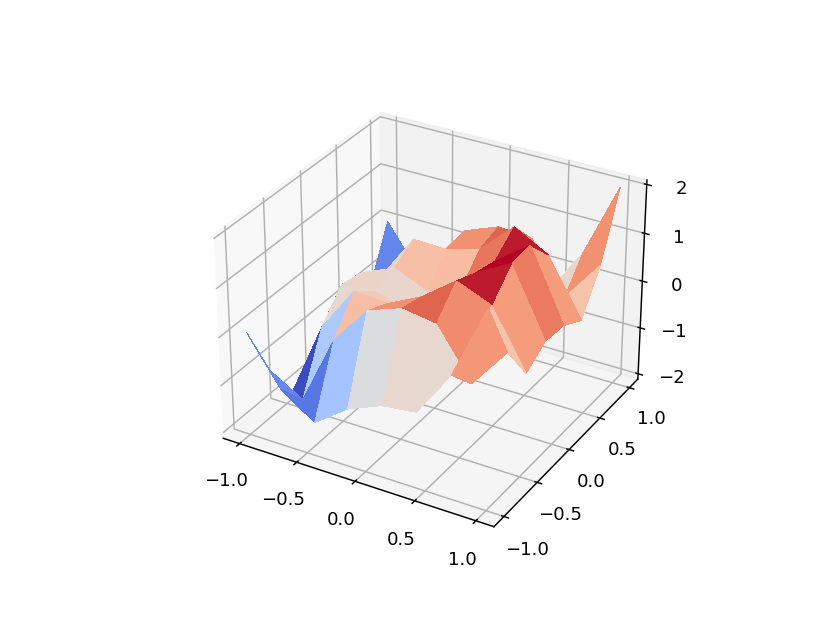

In [25]:
toy_X = gen_toy_data(show=True)

## Load the MNIST dataset

In [70]:
max_category_size = 50

digits = [3, 4]  # 3 and 4 are cherry picked.
# digits = list(range(10))

In [71]:
# Load the MNIST dataset.
data = sio.loadmat('mnist_digits.mat')

In [72]:
X = data['x']
Y = data['y']
n, dim = X.shape
print(f'The dataset has {n} examples of dimension {dim}.')

# Select only the digits in `digits`.
categories = [[]] * 10
for digit in digits:
    category = X[np.argwhere(Y == digit)[:, 0]]
    categories[digit] = category[:min(max_category_size, len(category))]

X = np.concatenate([categories[digit] for digit in digits], axis=0)
Y = np.concatenate([i * np.ones(len(category)) for i, category in enumerate(categories)], axis=0)

indices = [[]] * 10
for digit in digits:
    indices[digit] = np.argwhere(Y == digit)[:, 0]

n, dim = X.shape
print(f'The trimmed down dataset has {n} examples of dimension {dim}.')

# Add noise to the data.
sigma = .05
noisy_X = X + sigma * np.random.randn(*X.shape)

The dataset has 66000 examples of dimension 784.
The trimmed down dataset has 100 examples of dimension 784.


<IPython.core.display.Javascript object>


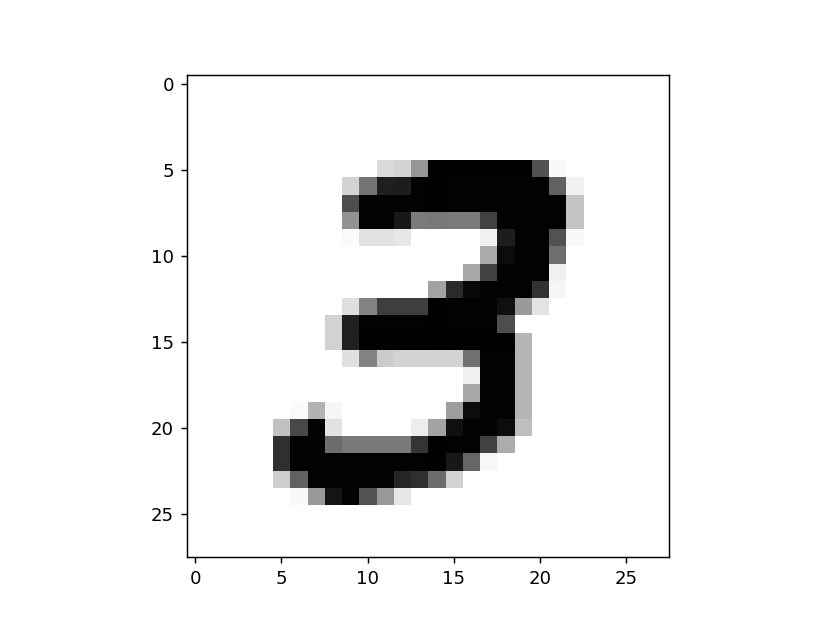

In [73]:
plt.imshow(np.reshape(X[0],(28,28)), cmap='binary')
plt.show()

Check the level of noise.

<IPython.core.display.Javascript object>


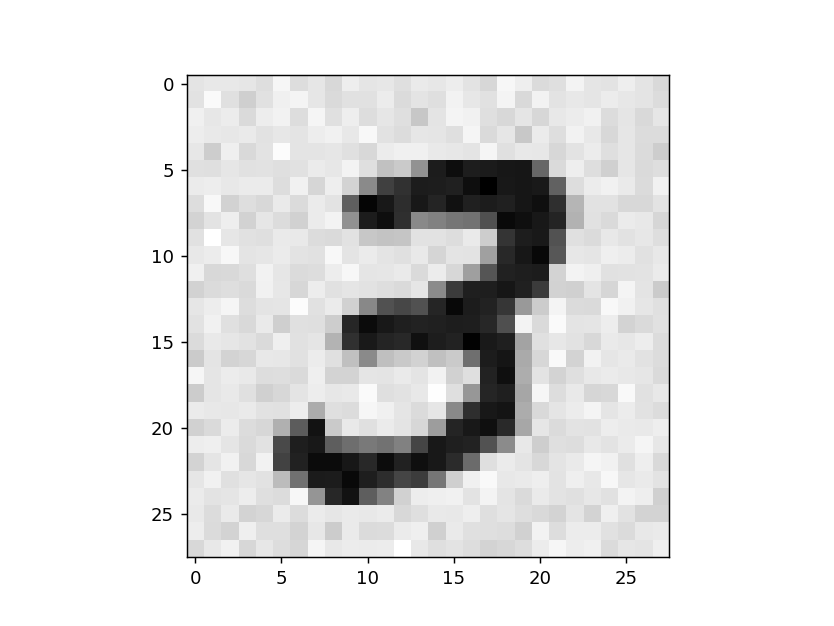

In [74]:
plt.imshow(np.reshape(noisy_X[0],(28,28)), cmap='binary')
plt.show()

## PCA

In [75]:
def pca(X, d=1, plot=False, label=''):
    # Assert that the data is centered.
    mean = np.mean(X, axis=0)
    X_centered = np.array([x - mean for x in X])
    
    # Compute the eigenvectors and eigenvalues.
    eig_val, eig_vect = np.linalg.eig(X_centered.T @ X_centered)
    # Remove the imaginary part.
    eig_val = np.real(eig_val)
    eig_vect = np.real(eig_vect)
    
    # Sort by eigen value.
    sort_idx = np.argsort(eig_val)
    sorted_eig_val = eig_val[sort_idx]
    sorted_eig_vect = eig_vect[sort_idx]
    
    # Plot the eigenvalues.
    if plot:
        plt.plot(np.maximum(sorted_eig_val, 10 ** (-11)), label=label)
        plt.yscale('log')

    # Compute the projection on the subspace.
    sub_space = sorted_eig_vect[-d:]
    Z = np.array([np.array([np.dot(v, x) for v in sub_space]) for x in X_centered + mean])
    
    return Z

In [76]:
def show_2d_pca(X, nb_points=100):
    Z = pca(X, d=2)
    for digit in digits:
        Z_digit = Z[indices[digit]][:nb_points]
        plt.scatter(Z_digit[:, 0], Z_digit[:, 1], label=f'{digit}')

    plt.title('MNIST PCA 2D')
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


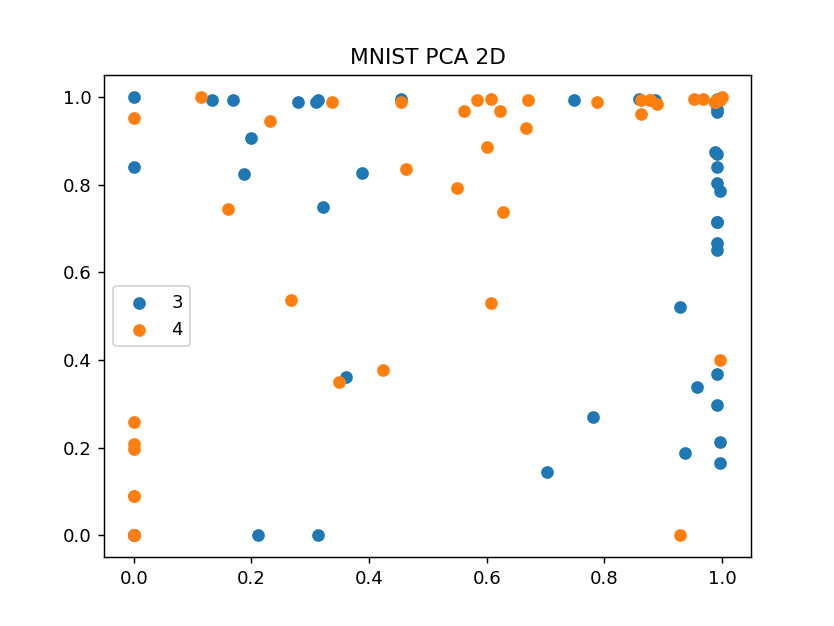

In [77]:
show_2d_pca(X)

<IPython.core.display.Javascript object>


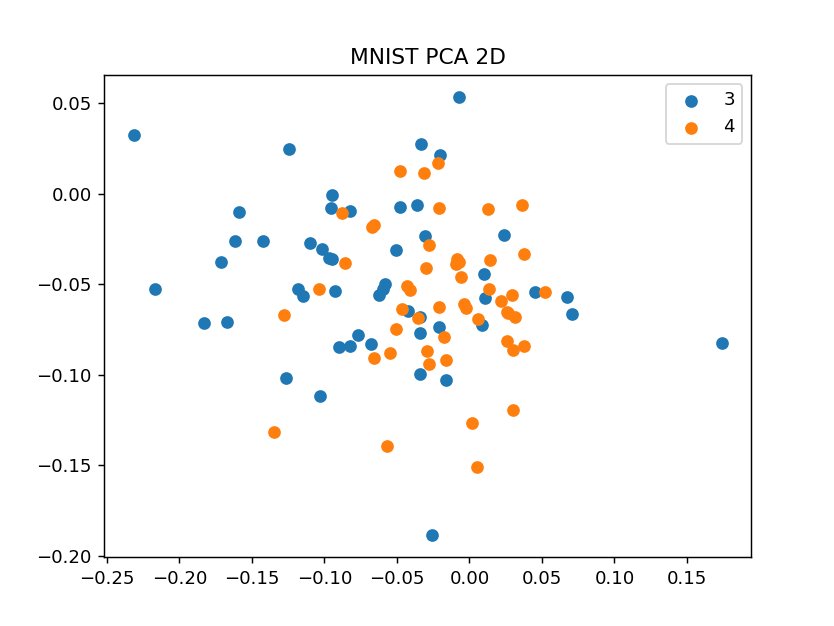

In [78]:
show_2d_pca(noisy_X)

## t-SNE

In [ ]:
def tsne(X, T, eta, alpha, per, toy=False, init_with_pca=True):
    """ 2D t-SNE """
    n = len(X)
    
    colors = ['green', 'blue', 'orange', 'purple', 'black', 'yelow', 'grey', 'brown', 'cyan', 'red']
    
    # Compute sigma for a given perplexity.
    # TODO
    sigma = np.array([
        binary_search(lambda x: 2 ** (-sum()), per, a, b, 1e-5) for i in rang(n)])
    sigma = np.ones(n) * 10 ** (-3)  # TODO
    
    # Compute p_{j|i}.
    N = np.array([[np.linalg.norm(X[i] - X[j]) ** 2 for i in range(n)] for j in range(n)])
    p = np.exp(- N ** 2 / (2 * sigma ** 2))
    # Normalize.
    for i in range(n):
        p[:, i] /= np.sum(p[:, i])
    
    # Compute p_{ji}.
    P = (p + p.T) / (2 * n)
    
    # Initial solution.
    if init_with_pca:
        Y = pca(X, d=2)
    else:
        Y = np.random.normal(0, 10 ** (-4), size=(n, 2))
    Y_old = np.copy(Y)
    
    # Training loop.
    for t in range(T):
        if t % (T // 10) == 0:
            # Plot the actual result.
            if toy:
                plt.scatter(Y[:, 0], Y[:, 1], label=f'{t}; iter {t}')
            else:
                for digit in digits:
                    plt.scatter(Y[indices[digit], 0], Y[indices[digit], 1], label=f'{digit}; iter {t}', c=colors[digit])
                plt.legend()
                plt.show()
    
        # Compute q_{ij}.
        Q = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                if i != j:
                    Q[i][j] = 1 / (1 + np.linalg.norm(Y[i] - Y[j]) ** 2)
            # Normalize.
            Q[i] /= np.sum(Q[i])

        # Compute de gradient.
        gradient = np.array(
            [4 * sum(
                (P[i, j] - Q[i, j]) * (Y[i] - Y[j]) / (1 + np.linalg.norm(Y[i] - Y[j]) ** 2)
                     for j in range(n))
             for i in range(n)])
        
        if t % (T // 10) == 0:
            # Print the cost and the gradient.
            cost = np.sum(P * np.maximum(np.log(np.maximum(P / (np.maximum(Q, 10 ** (-10))), 10 ** (-10))), -10 ** 30))
            print(f'Iteration {t}/{T}:\tcost {cost}\t\tgradient {np.linalg.norm(gradient)}')
        
        # Update Y and Y_old.
        Y, Y_old = Y + eta * gradient + alpha[t] * (Y - Y_old), Y
    
    return Y

In [ ]:
# Parameters.
T = 100
eta = .1
alpha = 0 * np.ones(T)
per = 1

Y = tsne(toy_X, T, eta, alpha, per, toy=True, init_with_pca=False)
plt.legend()
plt.show()

In [ ]:
# Parameters.
T = 100
eta = .05
alpha = 0 * np.ones(T)
per = 1

Y = tsne(X, T, eta, alpha, per, toy=False)
# noisy_Y = tsne(noisy_X, T, eta, alpha, per)

# TODO
- perplexity/sigma
- at first use PCA to reduce the dimention to 30
- remove for loops
- plot the cost
- normalize
- log and exp in base 2
- springs
- add gaussian noise to the map points in the early stages of optimization
- early compression
- early exaggeration
- random walk